# Amazon Deforestation Forecasting Using AI/ML and IoT Data
## AAI-530 Team 8 Final Project

Team 8:  Tyler Foreman

University of San Diego, Applied Artificial Intelligence

Date:  Feburary 11, 2023

GitHub Repository: https://github.com/t4ai/amazon-deforestation-forecasting

In [ ]:
# install necessary libraries
!pip install geopandas

In [154]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


## Exploratory Data Analysis

Load geospatial shape files and evaluate.  Objectives are:

1.  Interrogate time series layer: yearly_deforsestation_biome
2.  Visualize the time series layer
3.  Check for mising values
4.  Evaluate value ranges of target variable
5.  Interrogate supporting layers and determine how to create normalized analytical dataset


In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load geo data layers
root_dir = '/content/drive/MyDrive/USD/datasets/amazon_deforestation'
geo_yearly_deforestation_biome = gpd.read_file(root_dir + '/yearly_deforestation_biome/yearly_deforestation_biome.shp')

In [ ]:
geo_states_amazon_biome = gpd.read_file(root_dir + '/states_amazon_biome/states_amazon_biome.shp')

In [63]:
geo_hydrography_biome = gpd.read_file(root_dir + '/hydrography_biome/hydrography_biome.shp')

In [ ]:
geo_no_forest_biome = gpd.read_file(root_dir + '/no_forest_biome/no_forest_biome.shp')

### Interrogate the time series data layer

In [6]:
# display some samples
geo_yearly_deforestation_biome.sample(5)

,fid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry
645119,304529,PA,22466,DESMATAMENTO,d2009,0.0,220,2009-08-08,2009.0,0.204980,879.0,None,None,None,7483d079-c13c-4617-a819-25d90019e533,"POLYGON ((-50.64829 -9.11289, -50.64775 -9.112..."
634059,293356,RO,23267,DESMATAMENTO,d2016,0.0,200,2016-07-18,2016.0,0.047886,100246.0,None,None,None,9d5e153a-1bb8-495a-9949-b364a48fbdf6,"POLYGON ((-63.55738 -9.63049, -63.55738 -9.626..."
267084,537584,PA,22463,DESMATAMENTO,d2015,0.0,253,2015-09-10,2015.0,0.000019,2574.0,None,None,None,fcf4cc89-11b6-414b-9f66-d340f2d38981,"POLYGON ((-49.29495 -4.03690, -49.29495 -4.036..."
157783,446752,PA,22663,DESMATAMENTO,d2016,0.0,206,2016-07-24,2016.0,0.066167,100312.0,None,None,None,d14428a4-fcb0-40ce-878e-1e82c2735d84,"POLYGON ((-52.42078 -3.72384, -52.42073 -3.723..."
349009,546329,PA,22562,DESMATAMENTO,d2022,NaN,263,2022-09-20,2022.0,0.000005,1495.0,Amazonia,Landsat,OLI,94938eb5-c4f1-49d6-8f75-c391003ecc9d,"POLYGON ((-51.81478 -2.54962, -51.81479 -2.549..."


In [72]:
# print descriptive statistics
geo_yearly_deforestation_biome.describe()

,fid,def_cloud,julian_day,year,area_km,scene_id
count,666304.000000,510630.000000,666304.000000,666304.000000,666304.000000,665727.000000
mean,333152.500000,321.841846,219.746364,2015.468742,0.174381,20848.936883
std,192345.541219,737.740580,32.035579,4.530961,0.550267,39564.416673
min,1.000000,0.000000,1.000000,2008.000000,0.000000,1.000000
25%,166576.750000,0.000000,207.000000,2011.000000,0.065143,804.000000
50%,333152.500000,0.000000,219.000000,2016.000000,0.090982,1401.000000
75%,499728.250000,0.000000,233.000000,2019.000000,0.153751,2559.000000
max,666304.000000,2021.000000,363.000000,2022.000000,123.475783,101293.000000


In [11]:
#check data types
geo_yearly_deforestation_biome.dtypes

fid              int64
state           object
path_row        object
main_class      object
class_name      object
def_cloud      float64
julian_day       int64
image_date      object
year           float64
area_km        float64
scene_id       float64
source          object
satellite       object
sensor          object
uuid            object
geometry      geometry
dtype: object

In [12]:
# convert image_date to datetime
geo_yearly_deforestation_biome['image_date'] = pd.to_datetime(geo_yearly_deforestation_biome['image_date'])

In [52]:
# visualize the area_km total by year
yearly_deforestation = geo_yearly_deforestation_biome.groupby(pd.Grouper(key="image_date", freq="1Y")).sum()
yearly_deforestation['image_date'] = yearly_deforestation.index

<ipython-input-52-39dba510b50c>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_deforestation = geo_yearly_deforestation_biome.groupby(pd.Grouper(key="image_date", freq="1Y")).sum()


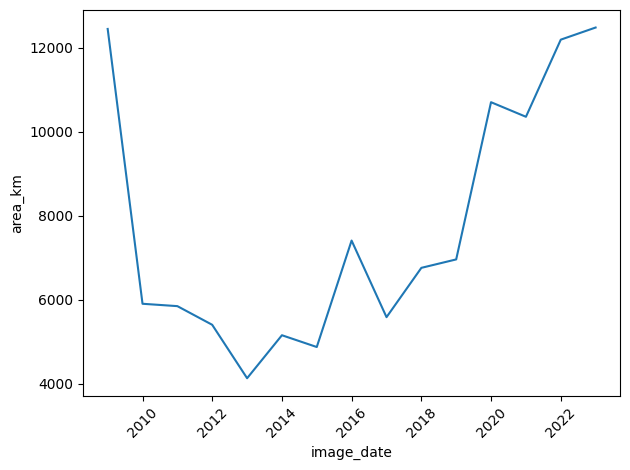

In [51]:
# line plot
sns.lineplot(x="image_date", y="area_km", data=yearly_deforestation)
plt.xticks(rotation=45)
plt.tight_layout()

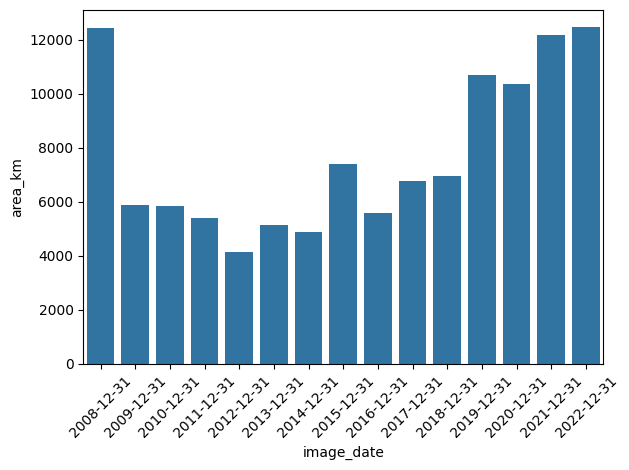

In [50]:
# show as bar graph
sns.barplot(x="image_date", y="area_km", data=yearly_deforestation)
plt.xticks(rotation=45)
plt.tight_layout()

In [39]:
# visualize the area_km total by state by year
state_deforestation = geo_yearly_deforestation_biome.groupby(['state', pd.Grouper(key="image_date", freq="1Y")]).sum()

<ipython-input-39-ad7e65832fbe>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  state_deforestation = geo_yearly_deforestation_biome.groupby(['state', pd.Grouper(key="image_date", freq="1Y")]).sum()


In [40]:
state_deforestation

fid  def_cloud  julian_day       year     area_km  \
state image_date                                                            
AC    2008-12-31  826890113   303057.0      629500  5433648.0  288.792419   
      2009-12-31  518115260     8031.0      423648  3471552.0  161.738798   
      2010-12-31  813567682  1018516.0      577216  5374740.0  265.366641   
      2011-12-31  924697382    68333.0      688288  6149638.0  295.785591   
      2012-12-31  760215623   249362.0      546148  5176876.0  270.534694   
...                     ...        ...         ...        ...         ...   
TO    2018-12-31   16060203        0.0       10505   104936.0    4.760367   
      2019-12-31   19752636     2018.0       16298   147387.0    9.619698   
      2020-12-31   23576626        0.0       16767   149480.0   10.115500   
      2021-12-31   23891082        0.0       16586   147533.0   11.300232   
      2022-12-31   70207011        0.0       35250   299256.0   16.442140   

                   scene_id  
state image_date             
AC    2008-12-31  1758175.0  
      2009-12-31  1536732.0  
      2010-12-31  3008895.0  
      2011-12-31  3960568.0  
      2012-12-31  4032307.0  
...                     ...  
TO    2018-12-31  5256270.0  
      2019-12-31     4196.0  
      2020-12-31    48622.0  
      2021-12-31    81571.0  
      2022-12-31   232259.0  

[135 rows x 6 columns]

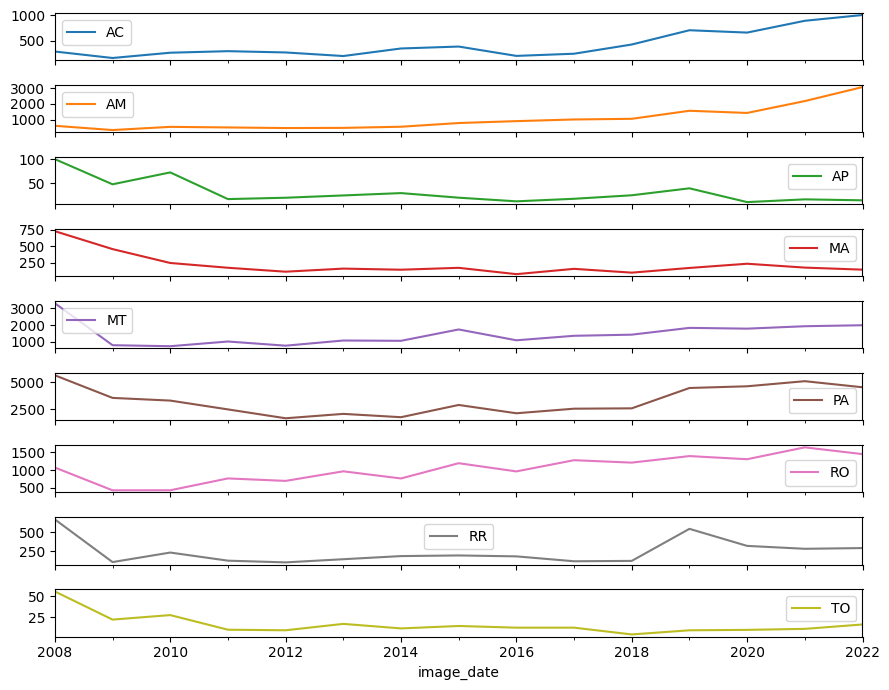

In [42]:
# plot by state
ax = state_deforestation.unstack(level=0).plot(kind='line', y='area_km', subplots=True, rot=0, figsize=(9, 7))
plt.tight_layout()

### Interrogate the supporting metadata layers

In [43]:
# check states metadata
geo_states_amazon_biome.sample(5)

,id,nome,sigla,geocodigo,geometry
2,4,Amazonas,AM,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112..."
4,6,Pará,PA,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ..."
8,26,Maranhão,MA,21,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ..."
7,14,Mato Grosso,MT,51,"MULTIPOLYGON (((-50.35017 -9.83338, -50.35059 ..."
1,3,Acre,AC,12,"POLYGON ((-66.62735 -9.89885, -66.62730 -9.899..."


In [53]:
# check hydrography metadata
geo_hydrography_biome.sample(5)

,fid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry
11366,11221,AM,00161,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,1.228369,0.0,None,None,None,cc06fa10-cd4c-41da-9ecd-475e41bc3f5a,"POLYGON ((-65.56585 -2.07769, -65.56531 -2.077..."
11033,10887,AM,00563,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,0.063284,0.0,None,None,None,2b4a7e54-d587-40b7-b6f4-a9f681f8e23f,"POLYGON ((-72.21786 -4.75310, -72.21749 -4.753..."
3405,3173,AM,00262,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,0.866748,0.0,None,None,None,235f4be9-70fd-4dbf-a505-b3d351b147db,"POLYGON ((-66.35630 -2.46428, -66.35603 -2.464..."
2937,2706,AM,22962,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,0.036933,0.0,None,None,None,f419baea-be83-4b35-ae79-ddd885ad37a1,"POLYGON ((-58.14720 -2.37257, -58.14651 -2.369..."
20026,19930,MA,22162,HIDROGRAFIA,HIDROGRAFIA,0.0,0.0,None,2007.0,0.521047,0.0,None,None,None,4aff59d2-740d-4c3f-b586-ec7e3559e95c,"POLYGON ((-45.16651 -3.40844, -45.16624 -3.408..."


In [46]:
# check metadata of areas with no forest
geo_no_forest_biome.sample(5)

,fid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry
49329,49164,RO,23166,NAO_FLORESTA,NAO_FLORESTA2,0.0,0.0,None,2007.0,0.010561,0.0,None,None,None,c5dbc5a1-335a-4137-a44f-7881603b6700,"POLYGON ((-61.72302 -8.95686, -61.72140 -8.956..."
929,462,MA,22062,NAO_FLORESTA,NAO_FLORESTA3,NaN,NaN,None,NaN,0.200163,NaN,amazon biome outside the legal amazon,Landsat,OLI,81be40eb-ebd8-43ba-9b50-8bee29e4c5a4,"POLYGON ((-43.96195 -3.38786, -43.96195 -3.387..."
50311,50146,PA,22861,NAO_FLORESTA,NAO_FLORESTA,0.0,0.0,None,2007.0,0.081924,0.0,None,None,None,03b0a62e-3deb-4899-a063-c38b46476f5c,"POLYGON ((-55.11342 -1.30059, -55.11073 -1.300..."
14523,14086,PA,22466,NAO_FLORESTA,NAO_FLORESTA2,0.0,0.0,None,2007.0,0.328769,0.0,None,None,None,a3c18af5-5aa9-4b70-93e8-dfbb1e3ea401,"POLYGON ((-50.81238 -9.39856, -50.80350 -9.398..."
30397,30132,PA,22666,NAO_FLORESTA,NAO_FLORESTA,0.0,0.0,None,2007.0,0.450727,0.0,None,None,None,6c04a72c-5bab-4f68-9d32-792c82ee5802,"POLYGON ((-54.03715 -8.09418, -54.03661 -8.094..."


### Hydrography and No Forest layers appear to have some time element, investigate these further

In [64]:
# start with hydrography
geo_hydrography_biome.describe()

,fid,def_cloud,julian_day,year,area_km,scene_id
count,32017.000000,31951.0,31951.0,31951.0,32017.000000,31951.0
mean,16009.000000,0.0,0.0,2007.0,3.411629,0.0
std,9242.656121,0.0,0.0,0.0,75.965504,0.0
min,1.000000,0.0,0.0,2007.0,0.000000,0.0
25%,8005.000000,0.0,0.0,2007.0,0.005568,0.0
50%,16009.000000,0.0,0.0,2007.0,0.067546,0.0
75%,24013.000000,0.0,0.0,2007.0,0.234795,0.0
max,32017.000000,0.0,0.0,2007.0,5616.250641,0.0


For hydrography, analysis shows that all of the data was collected in 2007, so just need to group and sum by state.

There appear to be some data gaps, so will need to do some cleanup potentially of this data.

In [71]:
# start with hydrography
geo_no_forest_biome.describe()

,fid,def_cloud,julian_day,year,area_km,scene_id
count,52528.000000,51942.0,51942.0,51942.0,52528.000000,51942.0
mean,26264.500000,0.0,0.0,2007.0,5.324204,0.0
std,15163.671807,0.0,0.0,0.0,131.468175,0.0
min,1.000000,0.0,0.0,2007.0,0.000000,0.0
25%,13132.750000,0.0,0.0,2007.0,0.033840,0.0
50%,26264.500000,0.0,0.0,2007.0,0.092565,0.0
75%,39396.250000,0.0,0.0,2007.0,0.285425,0.0
max,52528.000000,0.0,0.0,2007.0,18363.179058,0.0


No forest data is also all collected in 2007, so will group by state.

There appear to be some data gaps, so will need to do some cleanup potentially of this data.

## Data Cleanup and Preparation

Clean up the dataset and prepare for modeling.  Objectives are:

1.  Remove empty values
2.  Remove columns we do not need
3.  Summarize supporting datasets to state and year
4.  Merge dataset features from supporting datasets to time-series
5.  Normalize values
6.  One-hot encode categorical values


### Start cleanup of supporting layers
Cleanup and consolidate hydrography and no forest layers

<Axes: >

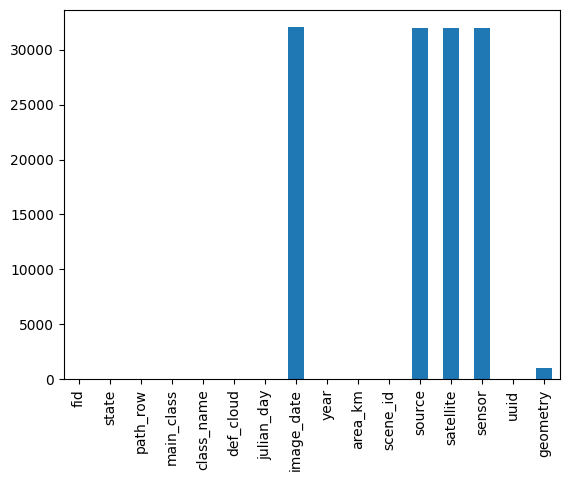

In [73]:
# visualize missing data
geo_hydrography_biome.isna().sum().plot.bar()

For hydrography layer, there are missing values but they are not relevant to our analysis.  We will drop columns we do not need.

---



In [76]:
# drop unnecessary columns
geo_hydrography_clean = geo_hydrography_biome.drop(['main_class', 'class_name', 'def_cloud', 'julian_day', 'image_date', 'scene_id', 'source', 'satellite', 'sensor'], axis=1)


In [77]:
geo_hydrography_clean.sample(5)

,fid,state,path_row,year,area_km,uuid,geometry
10491,10340,MT,22965,2007.0,0.064655,0ea0a8c3-8715-43cb-90cc-1c16494546e0,"POLYGON ((-58.20398 -7.62962, -58.20356 -7.629..."
12515,12360,AM,23364,2007.0,0.215861,40c95ea2-386e-4297-9284-7195b4644cb9,"POLYGON ((-64.54673 -5.00391, -64.54673 -5.001..."
551,319,AM,23063,2007.0,0.092415,ca7b5f93-fda6-41a6-9cf8-086d5446db22,"POLYGON ((-59.79861 -3.98117, -59.79808 -3.981..."
3496,3264,AM,00460,2007.0,0.058966,e2977249-50af-45f9-8867-f0721b248e01,"POLYGON ((-69.86567 0.57782, -69.86549 0.57838..."
13549,13394,AM,00261,2007.0,0.603826,22325f7e-d783-4bd0-a089-b0938b194210,"POLYGON ((-65.62784 -0.84786, -65.62354 -0.847..."


In [79]:
# roll up total area to the state level
geo_hydrography_state = geo_hydrography_clean.groupby(['state'])['area_km'].sum()

In [88]:
geo_hydrography_state.sample(9)

state
TO      395.633885
RO     1766.086970
AC      113.339475
AM    51077.536558
PA    44115.717775
MA     4818.959857
MT     1728.346000
AP     3461.356696
RR     1753.155361
Name: area_km, dtype: float64

<Axes: >

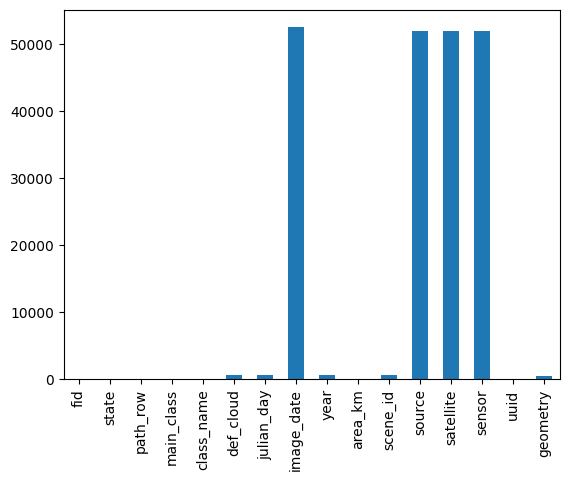

In [89]:
# visualize missing data
geo_no_forest_biome.isna().sum().plot.bar()

For no_forest layer, there are missing values but they are not relevant to our analysis.  We will drop columns we do not need.

In [91]:
# drop unnecessary columns
geo_noforest_clean = geo_no_forest_biome.drop(['main_class', 'class_name', 'def_cloud', 'julian_day', 'image_date', 'scene_id', 'source', 'satellite', 'sensor'], axis=1)

In [92]:
geo_noforest_clean.sample(5)

,fid,state,path_row,year,area_km,uuid,geometry
6453,5966,PA,22461,2007.0,6.055031e-02,eea11ff8-4afa-47f1-8c44-d00d809a9cd2,"POLYGON ((-49.23550 -1.37725, -49.23388 -1.377..."
7601,7128,PA,22366,2007.0,2.820000e-13,bb23d9f4-aaa3-4039-b0d4-83602886f6d8,"POLYGON ((-49.66186 -8.45238, -49.66186 -8.452..."
21220,20853,AM,23163,2007.0,2.795189e-01,66ed9f93-0b50-44e1-bf66-79762a6a8036,"POLYGON ((-61.12048 -5.03030, -61.12048 -5.031..."
3473,2974,MT,22567,2007.0,1.404229e-01,4c99b422-9d16-4eee-95a8-622197439f49,"POLYGON ((-53.14918 -9.95082, -53.14810 -9.950..."
31423,31174,RO,23267,2007.0,4.873863e-01,cbe5ffc9-60a1-4f05-b637-92d8e1db265a,"POLYGON ((-64.29358 -10.33979, -64.29304 -10.3..."


In [93]:
# roll up total area to the state level
geo_noforest_state = geo_noforest_clean.groupby(['state'])['area_km'].sum()

In [94]:
geo_noforest_state.sample(9)

state
MT    45068.972799
RR    60902.109316
MA     8166.208790
AM    48506.459703
AP    25883.222690
RO    23295.406781
AC       70.051073
TO      932.081272
PA    66845.300030
Name: area_km, dtype: float64

### Create calculated field for state dataset and merge in the hydrography and no_forest calcluated above for each state

In [116]:
# calculate area (km^2) for each state
geo_states_amazon_biome['area'] = gpd.GeoSeries(geo_states_amazon_biome['geometry']).to_crs(epsg=5880).area / 1000
geo_states_amazon_biome

,id,nome,sigla,geocodigo,geometry,area
0,2,Rondônia,RO,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811...",2.377802e+08
1,3,Acre,AC,12,"POLYGON ((-66.62735 -9.89885, -66.62730 -9.899...",1.707994e+08
2,4,Amazonas,AM,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112...",1.589484e+09
3,5,Roraima,RR,14,"POLYGON ((-60.18882 5.23222, -60.15748 5.23044...",2.253429e+08
4,6,Pará,PA,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09
5,7,Amapá,AP,16,"MULTIPOLYGON (((-49.98155 0.87511, -49.98229 0...",1.421043e+08
6,8,Tocantins,TO,17,"POLYGON ((-47.89974 -5.25030, -47.89995 -5.250...",2.478558e+07
7,14,Mato Grosso,MT,51,"MULTIPOLYGON (((-50.35017 -9.83338, -50.35059 ...",5.130396e+08
8,26,Maranhão,MA,21,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ...",1.137373e+08


In [118]:
# rename state to use as key
geo_states_amazon_biome = geo_states_amazon_biome.rename(columns={"sigla": "state"})

In [121]:
# mege hydrography area for each state
geo_states_amazon_merge_1 = geo_states_amazon_biome.merge(geo_hydrography_state, how='left', left_on='state', right_index=True)

In [126]:
# rename state to use as key
geo_states_amazon_merge_1 = geo_states_amazon_merge_1.rename(columns={"area_km": "hydro_area"})

In [127]:
geo_states_amazon_merge_1

,id,nome,state,geocodigo,geometry,area,hydro_area
0,2,Rondônia,RO,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811...",2.377802e+08,1766.086970
1,3,Acre,AC,12,"POLYGON ((-66.62735 -9.89885, -66.62730 -9.899...",1.707994e+08,113.339475
2,4,Amazonas,AM,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112...",1.589484e+09,51077.536558
3,5,Roraima,RR,14,"POLYGON ((-60.18882 5.23222, -60.15748 5.23044...",2.253429e+08,1753.155361
4,6,Pará,PA,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09,44115.717775
5,7,Amapá,AP,16,"MULTIPOLYGON (((-49.98155 0.87511, -49.98229 0...",1.421043e+08,3461.356696
6,8,Tocantins,TO,17,"POLYGON ((-47.89974 -5.25030, -47.89995 -5.250...",2.478558e+07,395.633885
7,14,Mato Grosso,MT,51,"MULTIPOLYGON (((-50.35017 -9.83338, -50.35059 ...",5.130396e+08,1728.346000
8,26,Maranhão,MA,21,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ...",1.137373e+08,4818.959857


In [128]:
# mege no forest area for each state
geo_states_amazon_merged = geo_states_amazon_merge_1.merge(geo_noforest_state, how='left', left_on='state', right_index=True)

In [129]:
# rename state to use as key
geo_states_amazon_merged = geo_states_amazon_merged.rename(columns={"area_km": "no_forest_area"})

In [130]:
geo_states_amazon_merged

,id,nome,state,geocodigo,geometry,area,hydro_area,no_forest_area
0,2,Rondônia,RO,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811...",2.377802e+08,1766.086970,23295.406781
1,3,Acre,AC,12,"POLYGON ((-66.62735 -9.89885, -66.62730 -9.899...",1.707994e+08,113.339475,70.051073
2,4,Amazonas,AM,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112...",1.589484e+09,51077.536558,48506.459703
3,5,Roraima,RR,14,"POLYGON ((-60.18882 5.23222, -60.15748 5.23044...",2.253429e+08,1753.155361,60902.109316
4,6,Pará,PA,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09,44115.717775,66845.300030
5,7,Amapá,AP,16,"MULTIPOLYGON (((-49.98155 0.87511, -49.98229 0...",1.421043e+08,3461.356696,25883.222690
6,8,Tocantins,TO,17,"POLYGON ((-47.89974 -5.25030, -47.89995 -5.250...",2.478558e+07,395.633885,932.081272
7,14,Mato Grosso,MT,51,"MULTIPOLYGON (((-50.35017 -9.83338, -50.35059 ...",5.130396e+08,1728.346000,45068.972799
8,26,Maranhão,MA,21,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ...",1.137373e+08,4818.959857,8166.208790


### Prepare time-series dataset

1. Inspect and clean as necessary
2. Drop unnecessary columns
3. Merge state data to time series
4. Normalize all numeric values
5. One-hot enc

<Axes: >

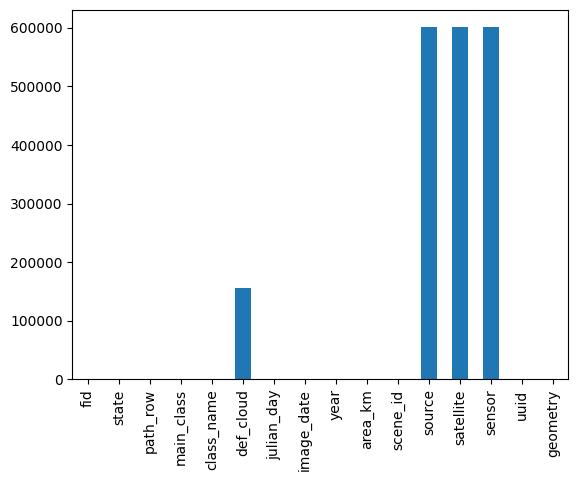

In [131]:
# visualize missing data
geo_yearly_deforestation_biome.isna().sum().plot.bar()

In [132]:
# drop columns we don't need
yearly_deforestation_clean = geo_yearly_deforestation_biome.drop(['main_class', 'class_name', 'def_cloud', 'julian_day', 'scene_id', 'source', 'satellite', 'sensor'], axis=1)

In [133]:
# merge state data in
yearly_deforestation_merged = yearly_deforestation_clean.merge(geo_states_amazon_merged, how='left', left_on='state', right_on='state')

In [135]:
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,area_km,uuid,geometry_x,id,nome,geocodigo,geometry_y,area,hydro_area,no_forest_area
546226,202245,AM,23366,2021-07-23,2021.0,0.082384,c6430b7a-cc98-4eda-aaf3-cf5a97fc0b5b,"POLYGON ((-65.45398 -9.24051, -65.45412 -9.240...",4,Amazonas,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112...",1.589484e+09,51077.536558,48506.459703
614970,273580,RO,23267,2016-02-09,2016.0,0.155153,b40d0321-18c9-4ff7-8203-a12befe604b1,"POLYGON ((-63.40292 -10.19223, -63.40290 -10.1...",2,Rondônia,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811...",2.377802e+08,1766.086970,23295.406781
327796,507844,AM,23065,2022-08-22,2022.0,0.081733,6a031f38-da73-4cb5-8b0b-594b9169c150,"POLYGON ((-60.00081 -6.62776, -60.00081 -6.627...",4,Amazonas,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112...",1.589484e+09,51077.536558,48506.459703
545485,201532,RO,23266,2008-07-28,2008.0,0.067406,083b88fe-3630-4188-8a6b-c599d2c79efe,"POLYGON ((-63.91674 -8.36207, -63.91620 -8.362...",2,Rondônia,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811...",2.377802e+08,1766.086970,23295.406781
570142,227161,AC,00268,2013-07-31,2013.0,0.007003,3e60d155-9fb9-46c4-9c4e-a2d49b4bf668,"POLYGON ((-69.00003 -10.77450, -69.00056 -10.7...",3,Acre,12,"POLYGON ((-66.62735 -9.89885, -66.62730 -9.899...",1.707994e+08,113.339475,70.051073


In [136]:
# clean up merged columns we don't need
yearly_deforestation_merged = yearly_deforestation_merged.drop(['nome', 'id', 'geocodigo', 'geometry_y'], axis=1)

In [137]:
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,area_km,uuid,geometry_x,area,hydro_area,no_forest_area
457480,110154,RO,23168,2008-07-05,2008.0,0.230706,66014c91-2735-4a83-87ab-11380be1448b,"POLYGON ((-62.28711 -12.10309, -62.28684 -12.1...",2.377802e+08,1766.086970,23295.406781
635986,295341,RO,23266,2016-02-09,2016.0,2.271260,e6cf7d3f-a599-4a6f-8cc4-2abed184570f,"POLYGON ((-63.15329 -8.68333, -63.15329 -8.683...",2.377802e+08,1766.086970,23295.406781
15397,342176,MT,22967,2014-08-09,2014.0,0.004392,008a0c5f-43e2-47e7-ba73-b5697e47e29c,"POLYGON ((-59.13013 -9.64443, -59.12986 -9.644...",5.130396e+08,1728.346000,45068.972799
612307,541287,AM,23165,2015-07-25,2015.0,0.004605,2420481f-c899-4f33-bfb6-f2e28cde191f,"POLYGON ((-61.81777 -6.59569, -61.81777 -6.595...",1.589484e+09,51077.536558,48506.459703
235510,538220,PA,22564,2021-07-15,2021.0,0.077409,a9376b7a-996a-492f-a103-75f761bb608b,"POLYGON ((-51.52753 -6.15631, -51.52753 -6.158...",1.238830e+09,44115.717775,66845.300030


In [138]:
# cleanup column names
yearly_deforestation_merged = yearly_deforestation_merged.rename(columns={"area": "state_area", "geometry_x": "geometry", "hydro_area": "state_hydro_area", "no_forest_area": "state_no_forest_area", "area_km": "deforest_area_km"})

In [141]:
yearly_deforestation_merged.sample(5)

,fid,state,path_row,image_date,year,deforest_area_km,uuid,geometry,state_area,state_hydro_area,state_no_forest_area
90526,357520,PA,22662,2017-07-27,2017.0,0.073907,9f91ac88-a4a1-4cb0-aac7-7050ca1c09dc,"POLYGON ((-52.68731 -2.93342, -52.68701 -2.933...",1.238830e+09,44115.717775,66845.300030
177249,642022,PA,22761,2010-07-31,2010.0,0.074200,2e344eec-6062-448b-b45b-a68e20fe3db4,"POLYGON ((-53.39333 -1.28041, -53.39316 -1.280...",1.238830e+09,44115.717775,66845.300030
185205,471149,MT,22971,2013-08-06,2013.0,0.121773,a3b73bf8-6051-49c2-94ba-8a599d0500f6,"POLYGON ((-59.61596 -15.88066, -59.61462 -15.8...",5.130396e+08,1728.346000,45068.972799
155794,444791,AM,23065,2013-08-29,2013.0,0.188351,d693cab8-88cb-4519-8a73-74bcdff27e18,"POLYGON ((-60.05629 -6.97407, -60.05575 -6.974...",1.589484e+09,51077.536558,48506.459703
525424,180169,PA,23060,2015-09-20,2015.0,0.054743,159bd0c3-bc31-41dd-b4b2-b97d36d9e94f,"POLYGON ((-58.09417 -0.43705, -58.09415 -0.437...",1.238830e+09,44115.717775,66845.300030


In [153]:
# extract lat and long into discreet columns
geo_states_amazon_biome['lat'] = gpd.GeoSeries(geo_states_amazon_biome['geometry']).to_crs(epsg=4326).centroid.y
geo_states_amazon_biome['long'] = gpd.GeoSeries(geo_states_amazon_biome['geometry']).to_crs(epsg=4326).centroid.x
geo_states_amazon_biome

<ipython-input-153-a28d853ed9ed>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_states_amazon_biome['lat'] = gpd.GeoSeries(geo_states_amazon_biome['geometry']).to_crs(epsg=4326).centroid.y
<ipython-input-153-a28d853ed9ed>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_states_amazon_biome['long'] = gpd.GeoSeries(geo_states_amazon_biome['geometry']).to_crs(epsg=4326).centroid.x


,id,nome,state,geocodigo,geometry,area,lat,long
0,2,Rondônia,RO,11,"MULTIPOLYGON (((-59.98861 -11.91000, -59.98811...",2.377802e+08,-10.894981,-62.873566
1,3,Acre,AC,12,"POLYGON ((-66.62735 -9.89885, -66.62730 -9.899...",1.707994e+08,-9.213404,-70.471945
2,4,Amazonas,AM,13,"POLYGON ((-73.79834 -7.11298, -73.79827 -7.112...",1.589484e+09,-4.155362,-64.652170
3,5,Roraima,RR,14,"POLYGON ((-60.18882 5.23222, -60.15748 5.23044...",2.253429e+08,2.082993,-61.390052
4,6,Pará,PA,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ...",1.238830e+09,-3.949286,-53.095065
5,7,Amapá,AP,16,"MULTIPOLYGON (((-49.98155 0.87511, -49.98229 0...",1.421043e+08,1.447151,-51.960444
6,8,Tocantins,TO,17,"POLYGON ((-47.89974 -5.25030, -47.89995 -5.250...",2.478558e+07,-7.155461,-48.635132
7,14,Mato Grosso,MT,51,"MULTIPOLYGON (((-50.35017 -9.83338, -50.35059 ...",5.130396e+08,-11.544631,-56.528616
8,26,Maranhão,MA,21,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ...",1.137373e+08,-3.483230,-45.892957


In [ ]:
# Normalize numeric area columns with min/max scaling
df[['x','z']] = mms.fit_transform(df[['x','z']])